In [ ]:
from google.colab import drive, files
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(os.listdir(os.getcwd()))

['.config', 'gdrive', 'sample_data']


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# shutil.rmtree('glasses')
# shutil.rmtree('images_no_black')
# shutil.rmtree('train')
# shutil.rmtree('val')
# shutil.rmtree('images_segm')

In [ ]:
print(os.listdir('/content/gdrive/MyDrive/data_samsung'))

['is_black_glasses.zip', 'no_black_glasses.zip', 'df_glasses.csv', 'images_segm', 'masks_segm', 'images_segm.zip', 'masks_segm.zip', 'df_glasses.zip', 'images_no_black.zip']


In [ ]:
!unzip /content/gdrive/MyDrive/data_samsung/images_segm.zip
!unzip /content/gdrive/MyDrive/data_samsung/images_no_black.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images_no_black/img-Glass001-451-13_chin_raiser-0-carpentry_shop_01-158-sunglasses.png  
  inflating: images_no_black/img-Glass001-451-13_chin_raiser-0-dam_road-272-sunglasses.png  
  inflating: images_no_black/img-Glass001-451-13_chin_raiser-0-theater_01-124-sunglasses.png  
  inflating: images_no_black/img-Glass001-451-13_chin_raiser-0-versveldpas-134-sunglasses.png  
  inflating: images_no_black/img-Glass001-451-7_jaw_left-2-zwinger_night-197-sunglasses.png  
  inflating: images_no_black/img-Glass001-452-12_dimpler-0-studio_small_04-339-sunglasses.png  
  inflating: images_no_black/img-Glass001-452-14_lip_puckerer-2-blue_lagoon-237-sunglasses.png  
  inflating: images_no_black/img-Glass001-452-14_lip_puckerer-2-de_balie-201-sunglasses.png  
  inflating: images_no_black/img-Glass001-452-14_lip_puckerer-2-gym_01-320-sunglasses.png  
  inflating: images_no_black/img-Glass001-452-14_lip_puckerer-2-wooden_lo

In [ ]:
os.makedirs('glasses', exist_ok=True)
os.makedirs('glasses/is_black', exist_ok=True)
os.makedirs('glasses/no_black', exist_ok=True)

In [ ]:
i = 0
for dirname, _, filenames in os.walk(f'/content/images_segm'):
    for filename in filenames:
        if i < 700:
            i += 1
            shutil.copy(os.path.join(dirname, filename), os.path.join(f'/content/glasses/is_black',filename))
        else:
            break
    if i >= 700:
        break
print(len(os.listdir(f'/content/glasses/is_black')))

700


In [ ]:
i = 0
for dirname, _, filenames in os.walk(f'/content/images_no_black'):
    for filename in filenames:
        if i < len(os.listdir(f'/content/glasses/is_black')):
            i += 1
            shutil.copy(os.path.join(dirname, filename), os.path.join(f'/content/glasses/no_black',filename))
        else:
            break
    if i >= len(os.listdir(f'/content/glasses/is_black')):
        break
print(len(os.listdir(f'/content/glasses/no_black')))

700


In [ ]:
os.makedirs('train', exist_ok=True)
os.makedirs('train/is_black', exist_ok=True)
os.makedirs('train/no_black', exist_ok=True)
os.makedirs('val', exist_ok=True)
os.makedirs('val/is_black', exist_ok=True)
os.makedirs('val/no_black', exist_ok=True)
os.makedirs('test', exist_ok=True)
os.makedirs('test/is_black', exist_ok=True)
os.makedirs('test/no_black', exist_ok=True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torchvision.transforms import v2
from random import shuffle, seed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2
from torch.utils.data import Dataset, DataLoader

In [ ]:
path_ser0 = pd.Series(['is_black/' + i for i in os.listdir('/content/glasses/is_black')], name='path')
class_ser0 = pd.Series([0 for i in os.listdir('/content/glasses/is_black')], name='class')
df0 = pd.concat([path_ser0, class_ser0], axis=1).sample(frac=1)

path_ser1 = pd.Series(['no_black/' + i for i in os.listdir('/content/glasses/no_black')], name='path')
class_ser1 = pd.Series([1 for i in os.listdir('/content/glasses/no_black')], name='class')
df1 = pd.concat([path_ser1, class_ser1], axis=1).sample(frac=1)

df = pd.concat([df0, df1]).sample(frac=1)
df

path  class
207  is_black/img-Glass006-380-12_dimpler-2-tucker_...      0
457  no_black/img-Glass004-410-18_grin-0-tiber_isla...      1
684  is_black/img-Glass008-458-19_cheek_blowing-2-k...      0
534  no_black/img-Glass004-458-19_cheek_blowing-2-k...      1
521  is_black/img-Glass007-377-12_dimpler-3-bethnal...      0
..                                                 ...    ...
537  is_black/img-Glass006-454-20_eye_closed-2-skyl...      0
373  no_black/img-Glass021-429-2_mouth_open-2-green...      1
76   no_black/img-Glass006-389-7_jaw_left-0-whipple...      1
604  no_black/img-Glass008-374-12_dimpler-2-stream-...      1
432  is_black/img-Glass009-374-11_mouth_right-2-neu...      0

[1400 rows x 2 columns]

In [ ]:
transforms_1 = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
    A.ShiftScaleRotate(scale_limit=(0.2, 0.6), rotate_limit=(-30,30), p=1),
    A.CropAndPad(px=(160, 224), p=1),
    A.RandomCrop(height=192, width=192, always_apply=True, p=1),
    A.Resize(height=380, width=380)
])

transforms_2 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=(0.2, 0.2), rotate_limit=(-30,30), p=1),
    A.CropAndPad(px=(160, 224), p=1),
    A.RandomCrop(height=192, width=192, always_apply=True, p=1),
    A.Resize(height=380, width=380)
])

transforms_3 = A.Compose([
    A.RandomCrop(height=224, width=224, always_apply=True),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
    A.ShiftScaleRotate(scale_limit=(0.2, 0.6), rotate_limit=(-30,30), p=1),
    A.Resize(height=380, width=380)
])

transforms_4 = A.Compose([
    A.RandomCrop(height=224, width=224, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=(0.2, 0.2), rotate_limit=(-30,30), p=1),
    A.Resize(height=380, width=380)
])


class ClassDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_path,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        #self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        self.root_path = root_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_path, self.df.iloc[index]['path'])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        aug = self.transforms_(image=img)
        img = aug['image']
        img = img / 255
        #img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        sample = (img, self.df.iloc[index]['class'])
        return sample

dataset_1 = ClassDataset(df, '/content/glasses', transforms_=transforms_1)
dataset_2 = ClassDataset(df, '/content/glasses', transforms_=transforms_2)
dataset_3 = ClassDataset(df, '/content/glasses', transforms_=transforms_3)
dataset_4 = ClassDataset(df, '/content/glasses', transforms_=transforms_4)

dataset = torch.utils.data.ConcatDataset([dataset_1, dataset_2, dataset_3, dataset_4])
len(dataset)

5600

In [ ]:
for ind, el in enumerate(dataset):
    if el[1] == 0:
        transforms.ToPILImage()(el[0]).save(f'/content/train/is_black/{ind}.png')
    else:
        transforms.ToPILImage()(el[0]).save(f'/content/train/no_black/{ind}.png')

In [ ]:
lst_is_black = os.listdir('/content/train/is_black')
lst_no_black = os.listdir('/content/train/no_black')
seed(1052024)
shuffle(lst_no_black)
seed(1052024)
shuffle(lst_is_black)
for el in lst_is_black[:240]:
    shutil.move(f'/content/train/is_black/{el}', f'/content/test/is_black')
for el in lst_is_black[240:752]:
    shutil.move(f'/content/train/is_black/{el}', f'/content/val/is_black')
for el in lst_no_black[:240]:
    shutil.move(f'/content/train/no_black/{el}', f'/content/test/no_black')
for el in lst_no_black[240:752]:
    shutil.move(f'/content/train/no_black/{el}', f'/content/val/no_black')

print(len(os.listdir('/content/train/no_black')),
      len(os.listdir('/content/train/is_black')),
      len(os.listdir('/content/val/no_black')),
      len(os.listdir('/content/val/is_black')),
      len(os.listdir('/content/test/no_black')),
      len(os.listdir('/content/test/is_black')))

2048 2048 512 512 240 240


In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder('/content/train', train_transforms)
val_dataset = torchvision.datasets.ImageFolder('/content/val', val_transforms)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

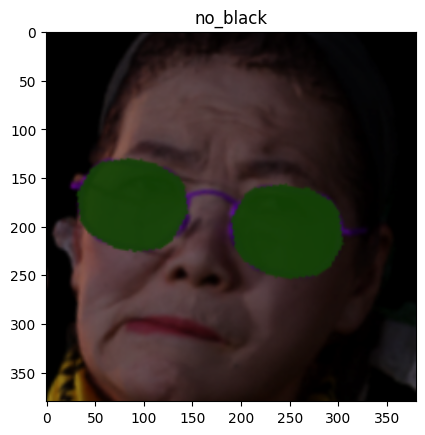

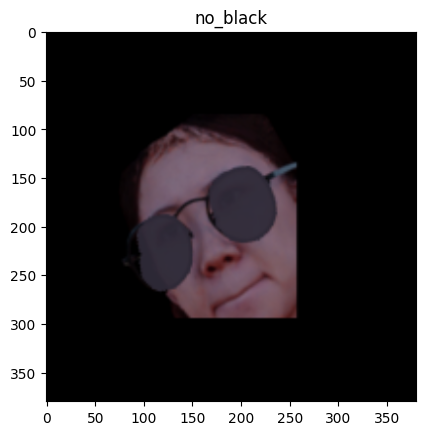

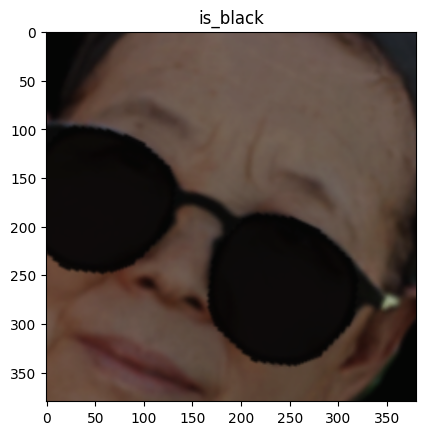

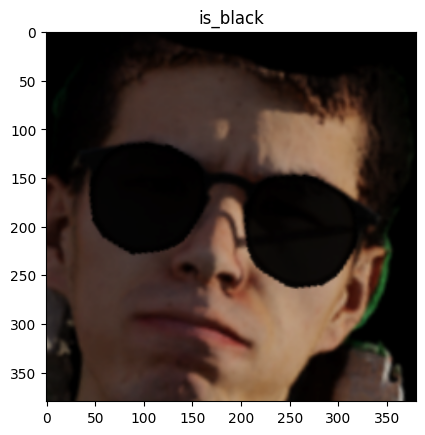

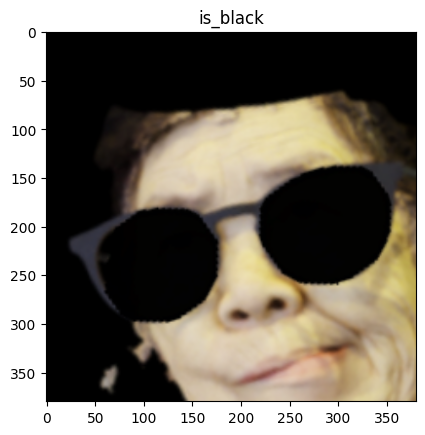

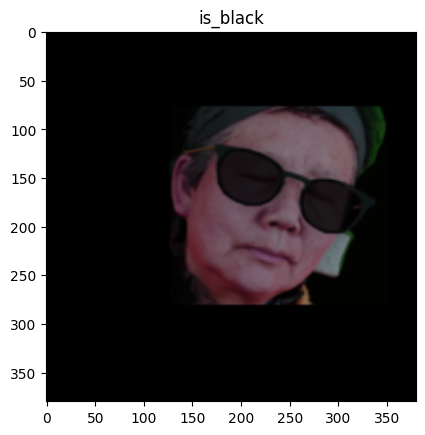

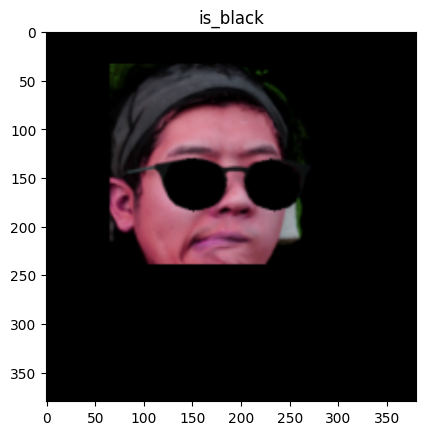

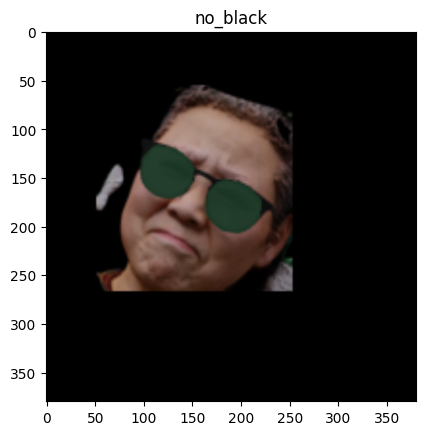

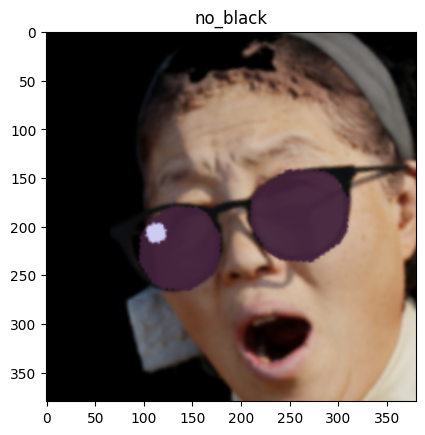

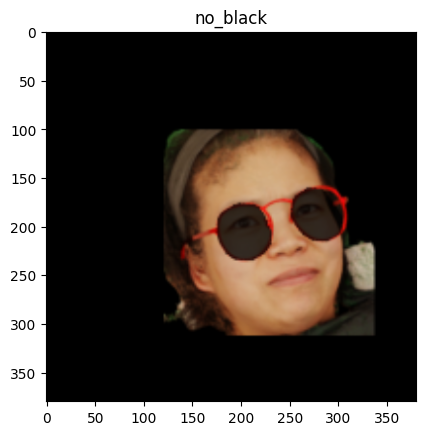

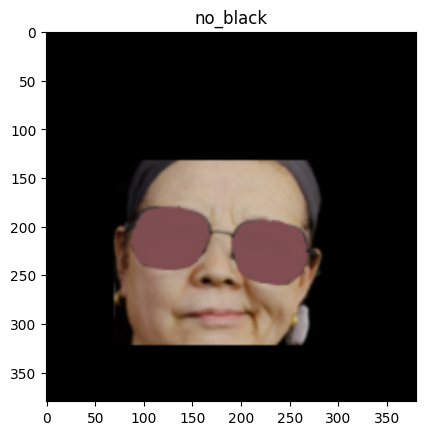

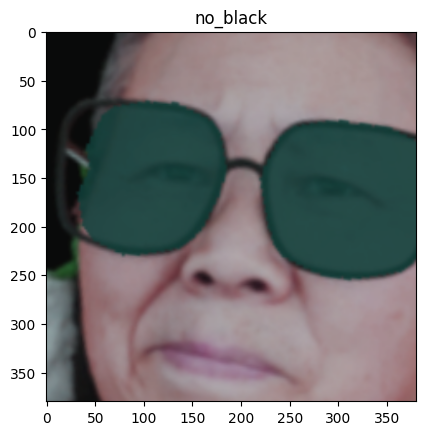

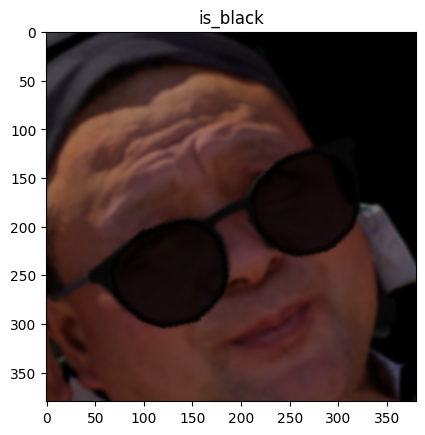

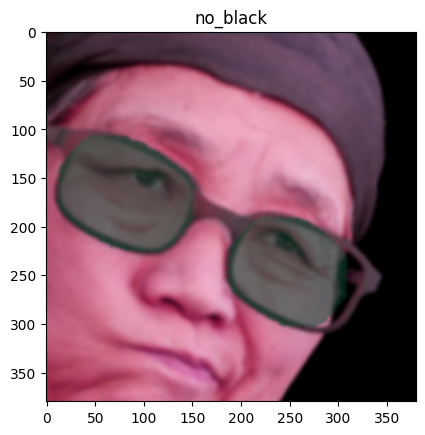

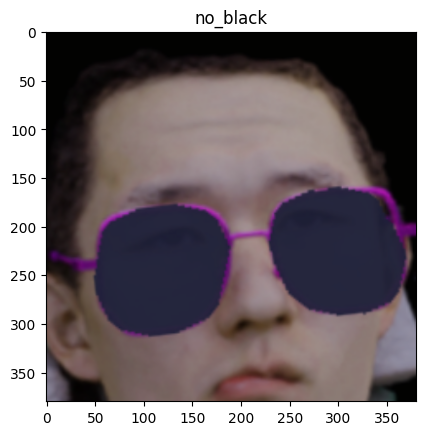

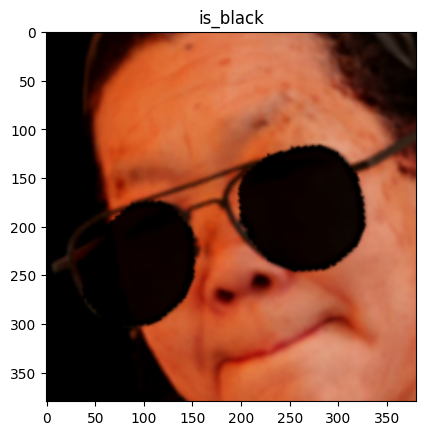

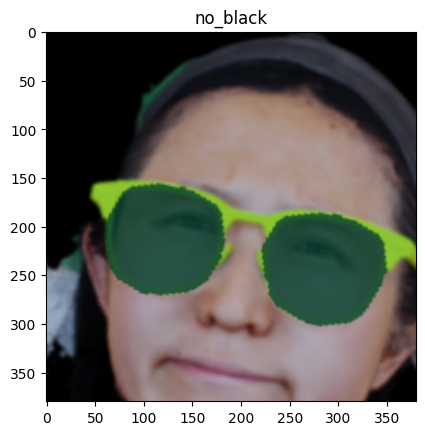

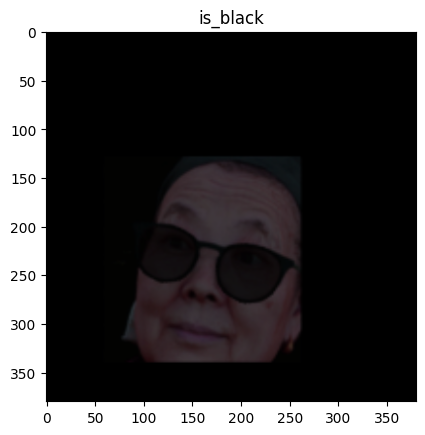

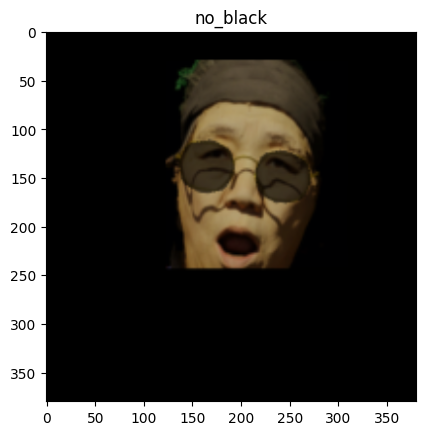

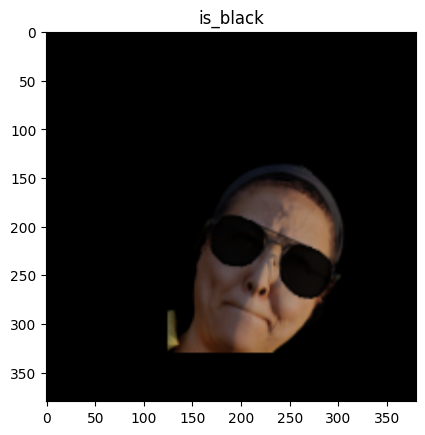

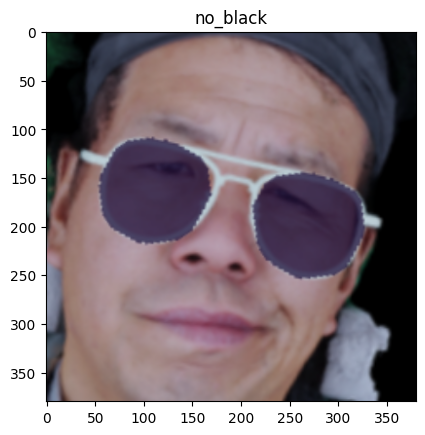

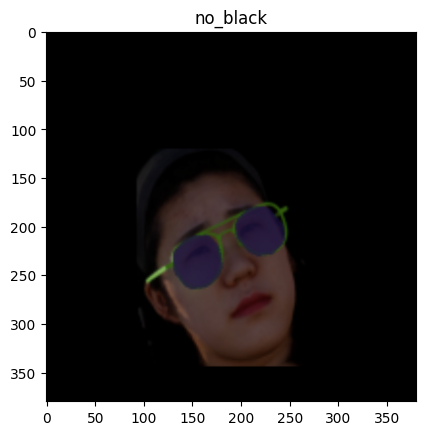

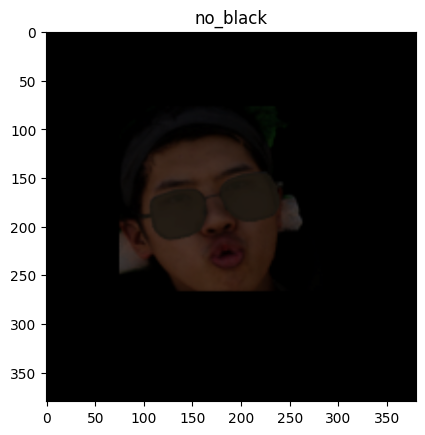

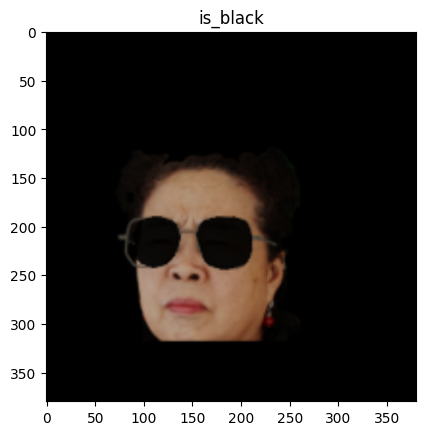

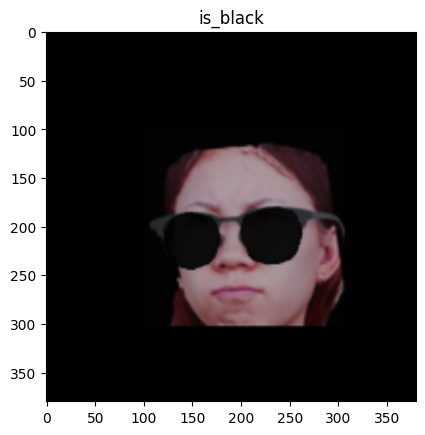

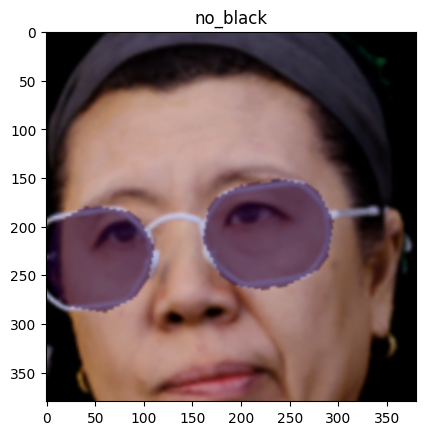

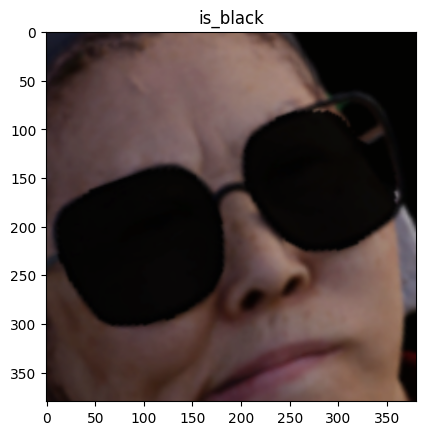

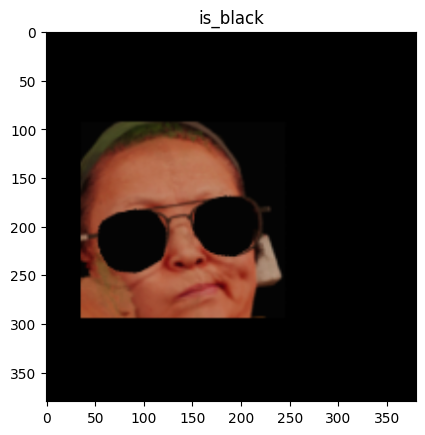

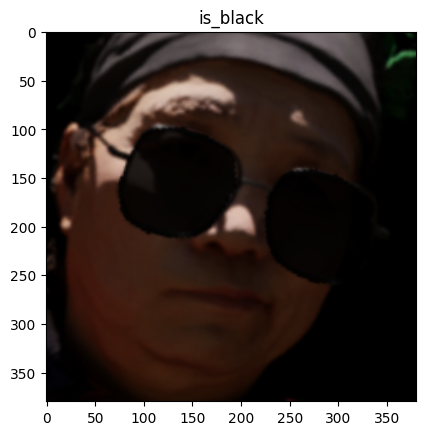

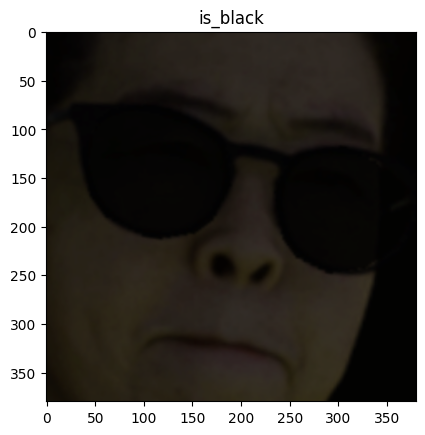

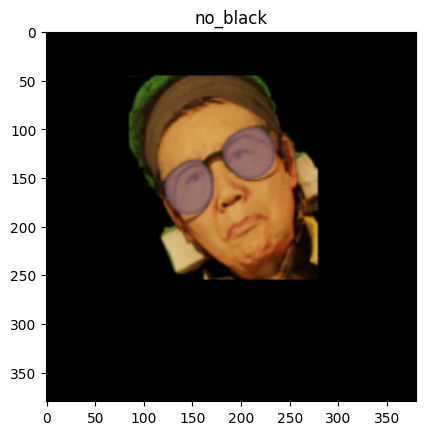

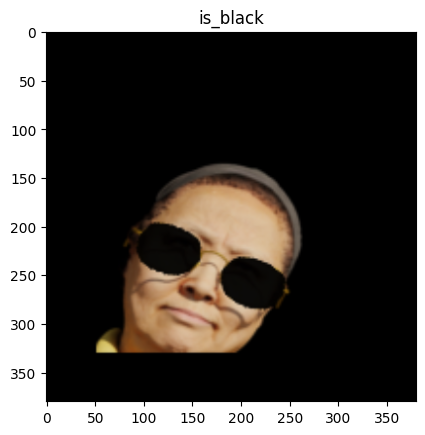

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
class_names = {0: 'is_black', 1: 'no_black'}

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names.get(int(y_item)))


In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step(loss_value)

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
# Download EfficientNet-b4 from TorchHub with pretrained weigths on ImagNet dataset
model = models.efficientnet_b4(pretrained=True)

In [ ]:
# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze 7, 8 block
for i in range(7, 9):
    for param in model.features[i].parameters():
        param.requires_grad = True

# change last full-connected layer (only two classes)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=8)

Epoch 0/7:


100%|██████████| 128/128 [01:19<00:00,  1.61it/s]

train Loss: 0.2303 Acc: 0.9065



100%|██████████| 32/32 [00:20<00:00,  1.53it/s]

val Loss: 0.1020 Acc: 0.9619
Epoch 1/7:



100%|██████████| 128/128 [01:14<00:00,  1.72it/s]

train Loss: 0.1505 Acc: 0.9426



100%|██████████| 32/32 [00:19<00:00,  1.64it/s]

val Loss: 0.1004 Acc: 0.9609
Epoch 2/7:



100%|██████████| 128/128 [01:15<00:00,  1.71it/s]

train Loss: 0.1497 Acc: 0.9453



100%|██████████| 32/32 [00:19<00:00,  1.65it/s]

val Loss: 0.0981 Acc: 0.9629
Epoch 3/7:



100%|██████████| 128/128 [01:16<00:00,  1.68it/s]

train Loss: 0.1554 Acc: 0.9436



100%|██████████| 32/32 [00:21<00:00,  1.52it/s]

val Loss: 0.0983 Acc: 0.9580
Epoch 4/7:



100%|██████████| 128/128 [01:16<00:00,  1.68it/s]

train Loss: 0.1647 Acc: 0.9399



100%|██████████| 32/32 [00:24<00:00,  1.31it/s]

val Loss: 0.1080 Acc: 0.9600
Epoch 5/7:



100%|██████████| 128/128 [01:15<00:00,  1.68it/s]

train Loss: 0.1530 Acc: 0.9468



100%|██████████| 32/32 [00:19<00:00,  1.63it/s]

val Loss: 0.0928 Acc: 0.9629
Epoch 6/7:



100%|██████████| 128/128 [01:15<00:00,  1.69it/s]

train Loss: 0.1418 Acc: 0.9482



100%|██████████| 32/32 [00:19<00:00,  1.61it/s]

val Loss: 0.0907 Acc: 0.9668
Epoch 7/7:



100%|██████████| 128/128 [01:14<00:00,  1.71it/s]

train Loss: 0.1580 Acc: 0.9424



100%|██████████| 32/32 [00:19<00:00,  1.62it/s]

val Loss: 0.0892 Acc: 0.9658


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
torch.save(model, '/content/mymodel_trans4')

In [ ]:
files.download('/content/mymodel_trans4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_dataset = ImageFolderWithPaths('/content/test', val_transforms)
#print(test_dataset[0])

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

len(np.where(test_predictions[:240] < 0.5)[0]) / 240, len(np.where(test_predictions[240:] > 0.5)[0]) / 240

100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


(0.9708333333333333, 0.9666666666666667)

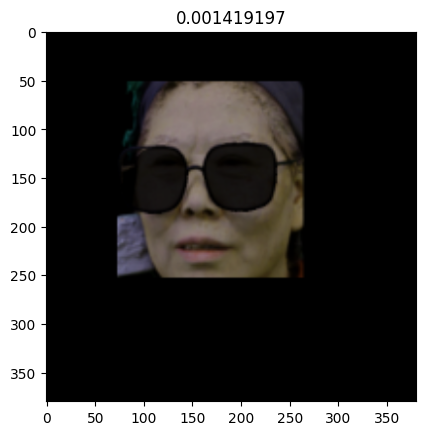

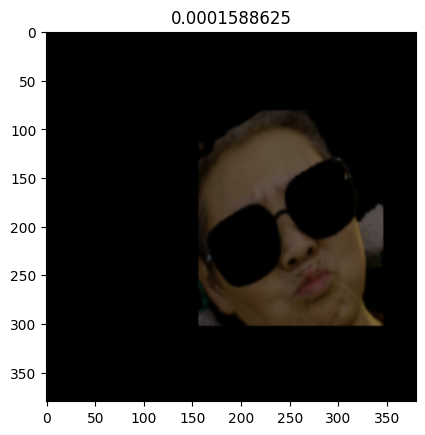

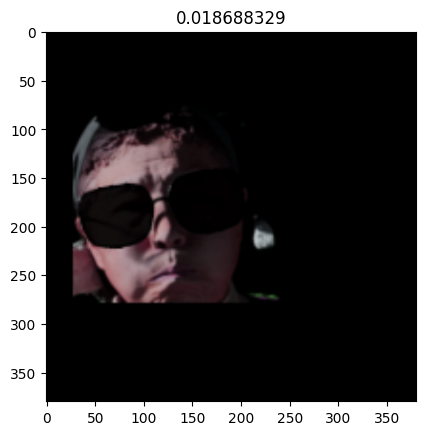

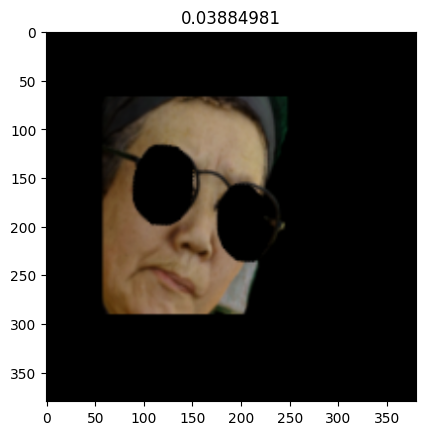

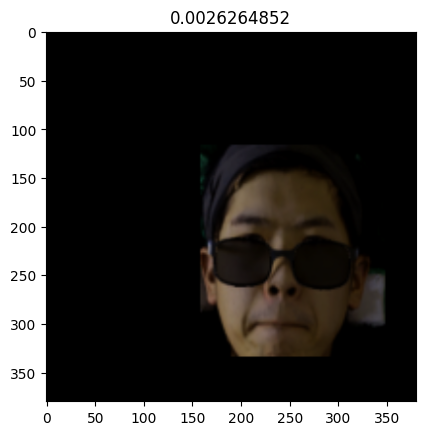

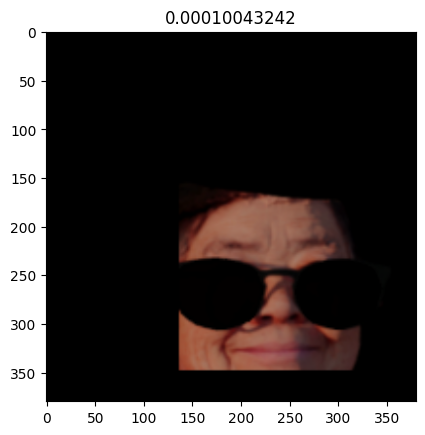

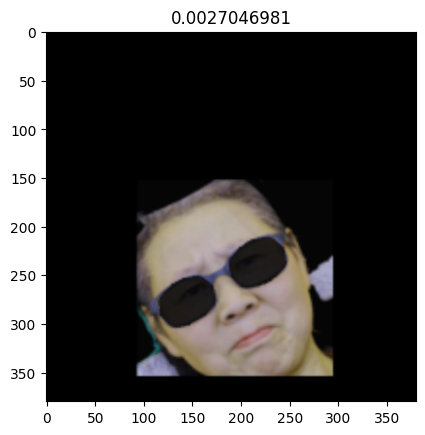

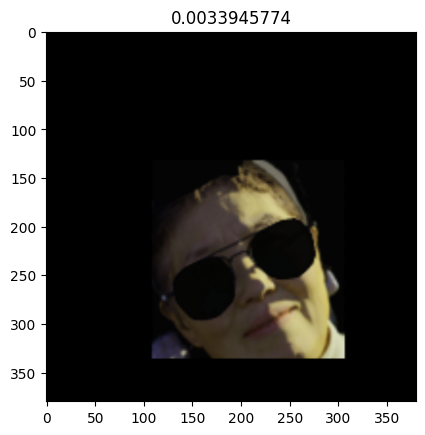

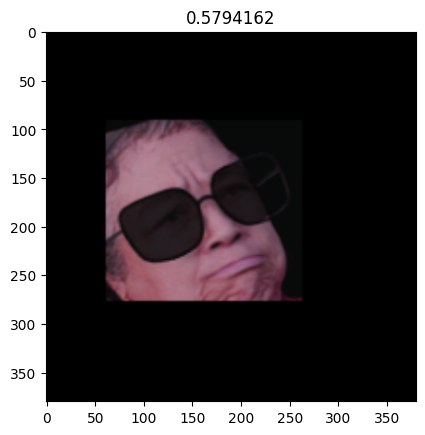

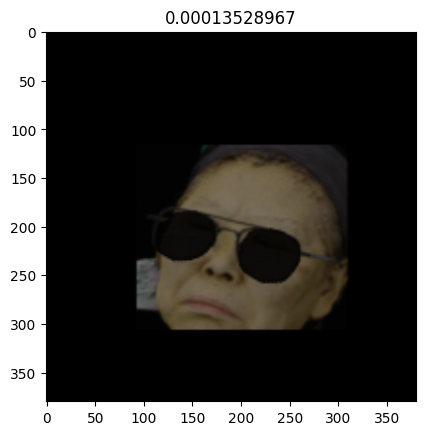

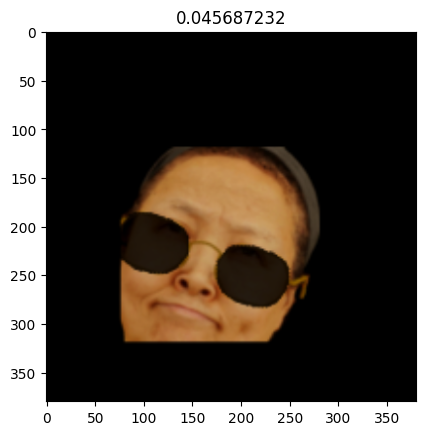

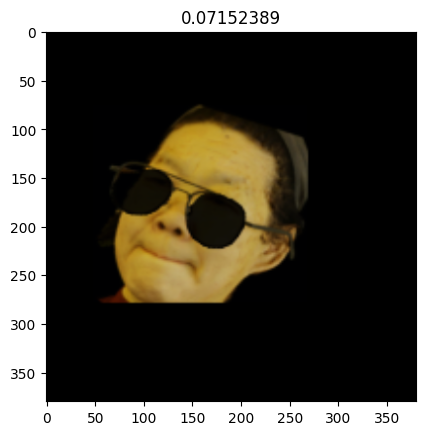

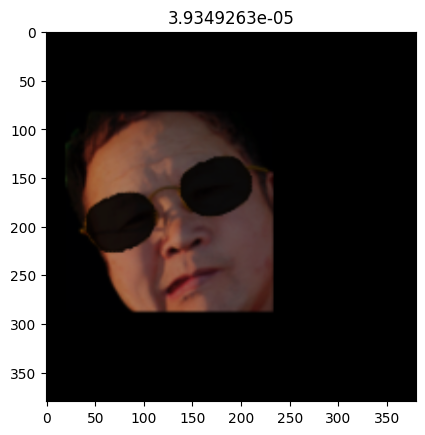

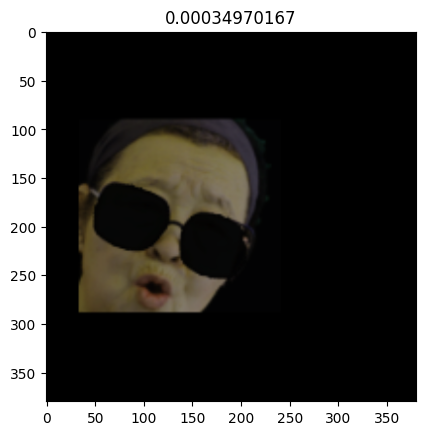

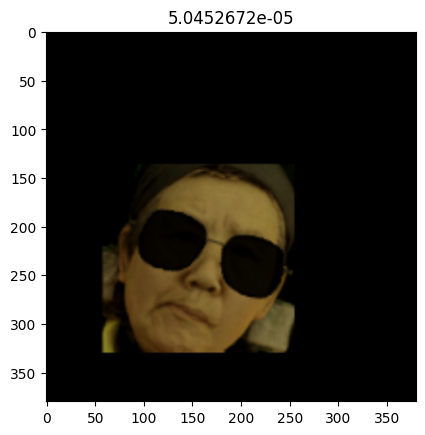

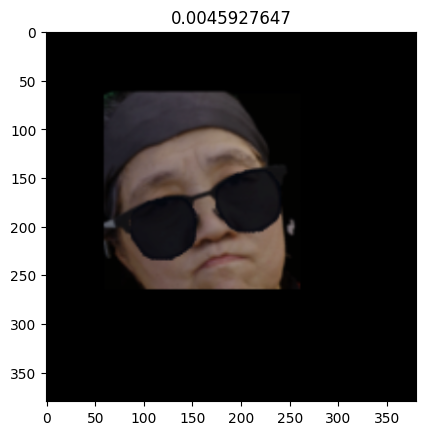

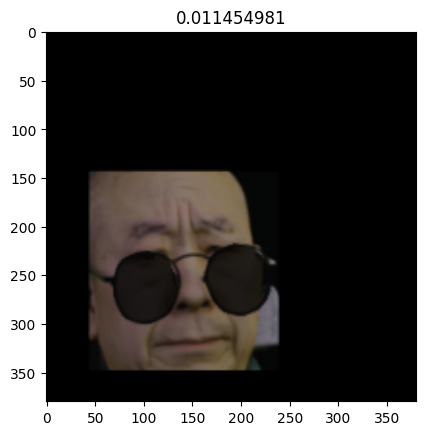

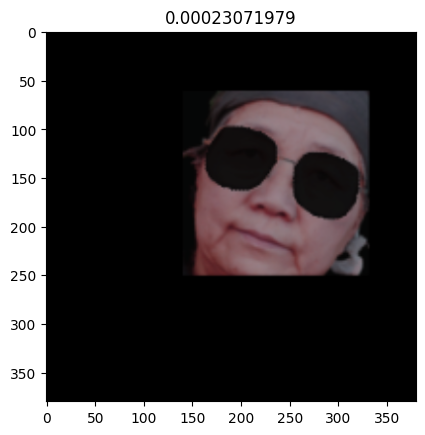

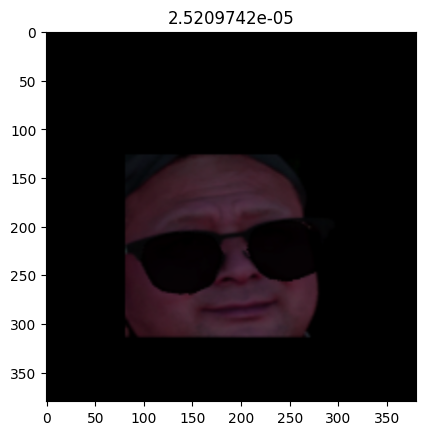

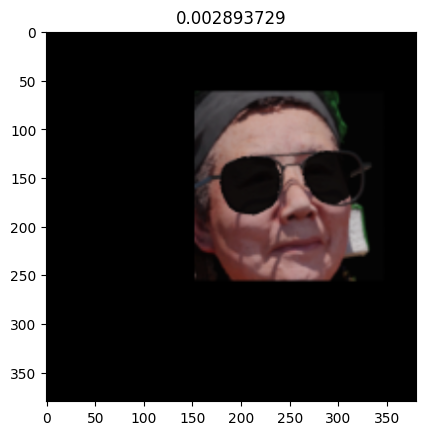

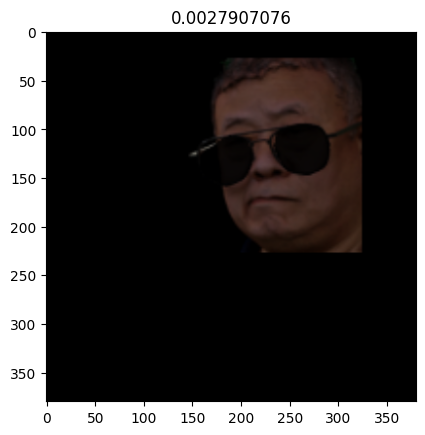

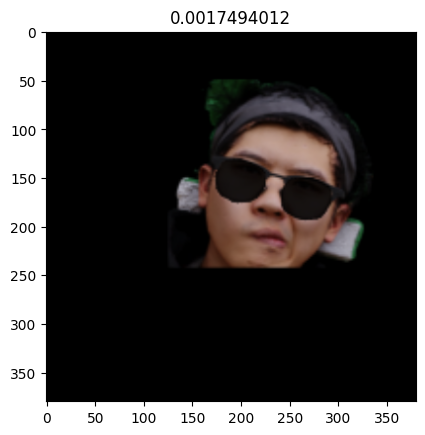

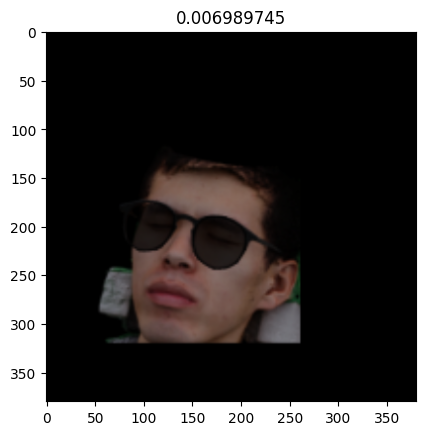

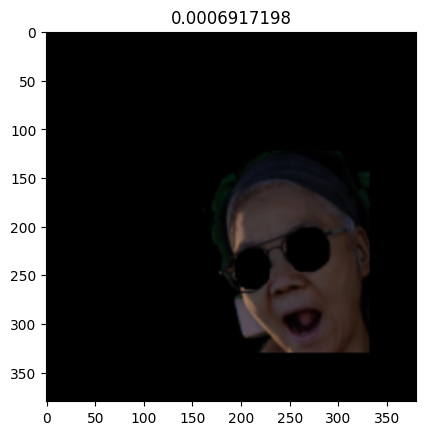

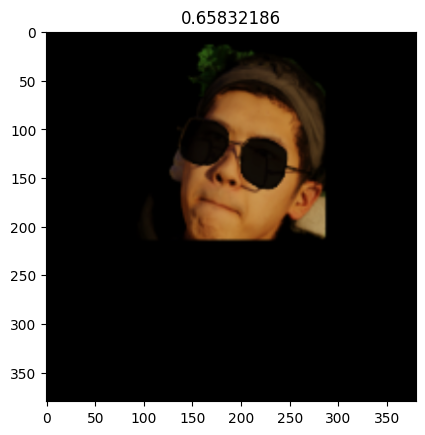

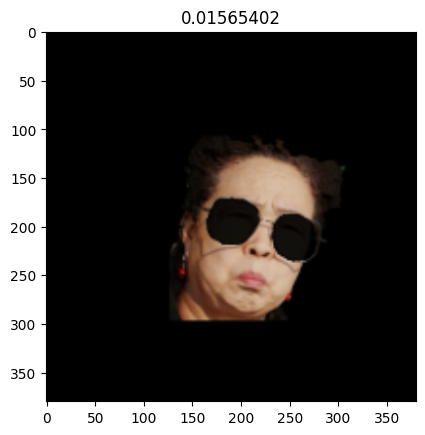

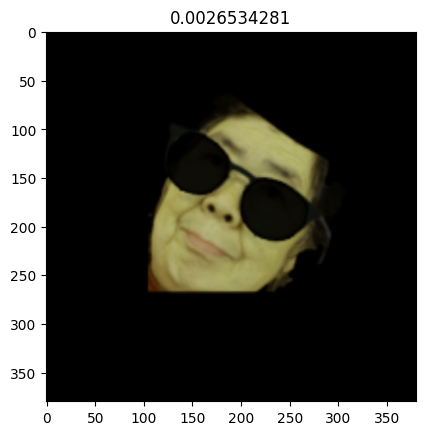

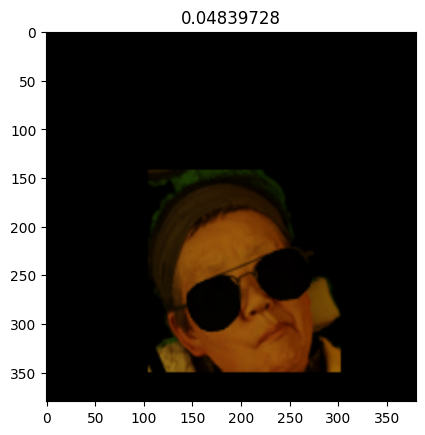

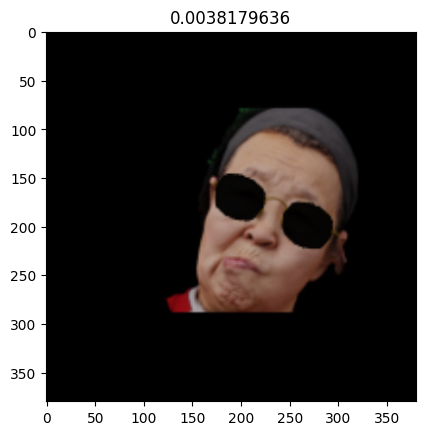

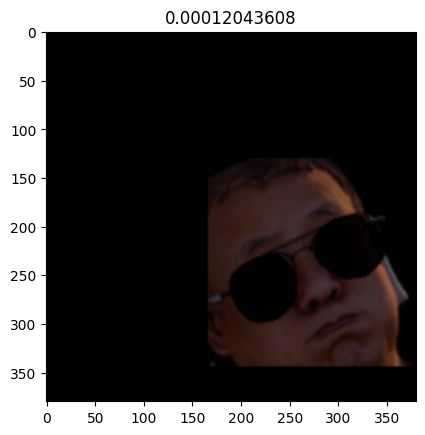

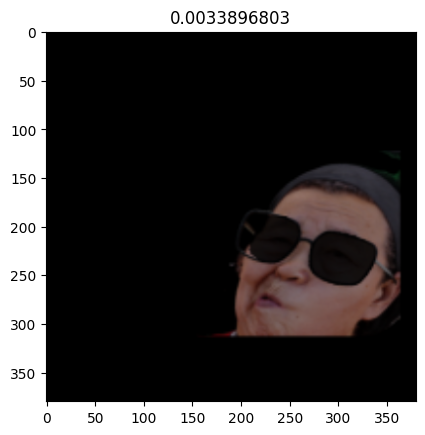

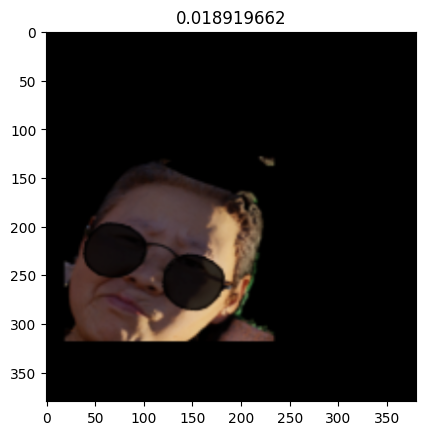

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))
for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)